In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import dill

In [322]:
SP = pd.read_csv('data/SP2000.csv').dropna()
SP.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6192,2020-11-19,3562.0,3582.75,3542.25,3580.00,3580.00,1291117.0
6193,2020-11-20,3560.0,3582.50,3542.75,3554.25,3554.25,1189621.0
6195,2020-11-23,3546.5,3588.00,3545.50,3576.00,3576.00,1204848.0
6196,2020-11-24,3576.0,3640.00,3575.25,3632.75,3632.75,1288993.0
6197,2020-11-25,3635.5,3655.00,3615.25,3627.25,3627.25,1016343.0


In [323]:
# SP.rename(columns={'GOLDAMGBD228NLBM': 'Close'}, inplace=True)
SP.Close = SP.Close.apply(pd.to_numeric, errors='coerce')
SP.Close = SP.Close.fillna(method='ffill')

In [324]:
SP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5134 entries, 0 to 6197
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5134 non-null   object 
 1   Open       5134 non-null   float64
 2   High       5134 non-null   float64
 3   Low        5134 non-null   float64
 4   Close      5134 non-null   float64
 5   Adj Close  5134 non-null   float64
 6   Volume     5134 non-null   float64
dtypes: float64(6), object(1)
memory usage: 320.9+ KB


In [325]:
i = 1
f = [1, 2]

for i in range(15):
    i = f[-1] + f[-2]
    f.append(i)
    
print(f)

[1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584]


In [326]:
df = []

#с конца всего датасета
for i in range(5000):
    period_pred = 10
    chnd = (SP.Close.iloc[-2 - i - period_pred]/SP.Close.iloc[-1 - i] - 1)*100
    row = []
    if chnd > 3:
        row.append(1)
    else:
        row.append(0)
    for j in (2, 3, 5, 8, 13, 21, 34):
        row.append(SP.Close.iloc[-j - i - period_pred])
    df.append(row)



In [327]:
df = pd.DataFrame(df)
df.columns = ['0', '1', '2', '3', '4', '5', '6', '7']
df.tail()

,0,1,2,3,4,5,6,7
4995,0,1132.75,1152.50,1169.75,1196.50,1256.75,1257.25,1353.25
4996,1,1152.50,1180.50,1171.25,1178.00,1243.75,1256.50,1382.50
4997,1,1180.50,1169.75,1167.00,1231.75,1234.00,1285.25,1373.50
4998,0,1169.75,1171.25,1196.50,1265.50,1243.50,1305.00,1382.75
4999,0,1171.25,1167.00,1178.00,1265.75,1242.00,1333.00,1370.00


In [328]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, classification_report, precision_recall_curve, confusion_matrix

In [329]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['0'], 1), df['0'], random_state=0)

In [330]:
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    

continuous_columns = ['1', '2', '3', '4', '5', '6', '7']

final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)[:, 1]

In [331]:
with open('rf.dill', 'wb') as in_strm:
    in_strm.write(dill.dumps(pipeline))

In [332]:
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# preds = rf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

# roc_auc = roc_auc_score(y_true=y_test, y_score=preds)
# fscore = (2 * precision/50 * recall) / (precision/50 + recall)
# # locate the index of the largest f score
# ix = np.argmax(fscore)
# print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
#                                                                         fscore[ix],
#                                                                         precision[ix],
#                                                                         recall[ix]))

# roc_auc = roc_auc_score(y_true=y_test, y_score=preds)
# print(roc_auc)

Best Threshold=0.250, F-Score=0.523, Precision=0.454, Recall=0.617


In [333]:
y_test.value_counts(normalize=True)

0    0.8664
1    0.1336
Name: 0, dtype: float64

In [334]:
preds = pipeline.predict_proba(df.drop(['0'], 1))[:, 1]
preds

array([0.25, 0.24, 0.18, ..., 0.73, 0.11, 0.15])

In [335]:
len(preds)

5000

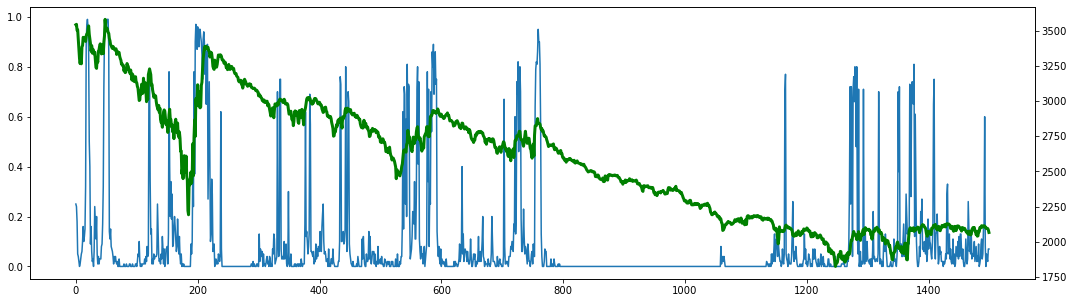

In [336]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(18, 5)
lns1 = ax.plot(preds[:1500])
ax2 = ax.twinx()
lns2 = ax2.plot(df['1'][:1500], linewidth=3, c='g', label='y')
lns = lns1+lns2
plt.show()

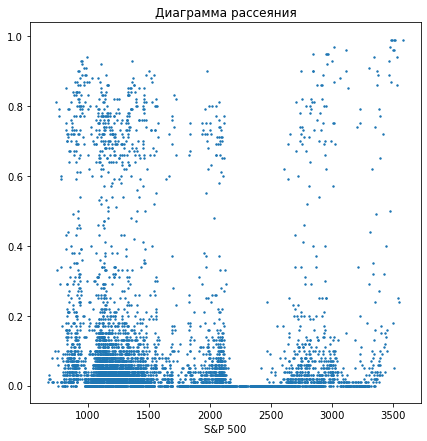

-0.07649631571004588

In [337]:
plt.figure(figsize=(7,7))
plt.scatter(df['1'], preds, s=2)
plt.title('Диаграмма рассеяния')
plt.xlabel('S&P 500')
# plt.ylabel('казначейские облигации')
plt.show()
df['1'].corr(pd.Series(preds))
